# Galaxy Examples - Classification Visualization

This notebook creates publication-quality grids of galaxy examples from the BYOL merger analysis:
- **Layout**: N rows (galaxies) × 3 columns (visualization types)
- **Visualizations**: HSC r-N708-i RGB, HSC i-band (LSB), Starlet HF
- **Galaxy selection**: merger candidates, ambiguous, undisturbed, fragmented examples
- **Automatic cutout fetching**: Pulls missing gri RGB cutouts from cluster if needed

## Configuration
This notebook is config-driven:
- Main config (`../config.yaml`): BYOL data paths, label file
- Figures config (`../configs/figures_config.yaml`): galaxy selection, visualization params

## Setup and Imports

In [1]:
import os
import sys
import pickle
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.visualization import make_lupton_rgb
from astropy import coordinates

# Add pieridae to path
sys.path.insert(0, str(Path.cwd().parent.parent))

from carpenter import conventions, pixels
from pieridae.starbursts import sample

# Import ekfplot if available
try:
    from ekfplot import plot as ek
    EKFPLOT_AVAILABLE = True
    print("✅ ekfplot available")
except ImportError:
    EKFPLOT_AVAILABLE = False
    print("⚠️  ekfplot not available, using standard matplotlib")

print("📦 Imports completed successfully")

✅ ekfplot available
📦 Imports completed successfully


## Load Configuration

In [393]:
def load_config(config_path: str):
    """Load configuration from YAML file"""
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config

# Load main config (BYOL analysis paths)
main_config_path = Path.cwd().parent / 'config.yaml'
main_config = load_config(main_config_path)

# Load figures config (galaxy selection and visualization)
figures_config_path = Path.cwd().parent / 'configs' / 'figures_config.yaml'
figures_config = load_config(figures_config_path)

# Convert paths to Path objects
main_config['data']['input_path'] = Path(main_config['data']['input_path'])
main_config['data']['output_path'] = Path(main_config['data']['output_path'])

print(f"📋 Main config loaded from: {main_config_path}")
print(f"📋 Figures config loaded from: {figures_config_path}")
print(f"📁 BYOL input path: {main_config['data']['input_path']}")
print(f"📁 BYOL output path: {main_config['data']['output_path']}")
print(f"📁 Figure output: {figures_config['figure_output']['output_dir']}")

📋 Main config loaded from: /Users/kadofong/work/projects/merian/pieridae/merger_analysis/config.yaml
📋 Figures config loaded from: /Users/kadofong/work/projects/merian/pieridae/merger_analysis/configs/figures_config.yaml
📁 BYOL input path: ../../local_data/pieridae_output/starlet/msorabove_v0
📁 BYOL output path: ../output
📁 Figure output: ../figures/


## Load Catalog and Adjust Stellar Masses

In [3]:
# Load catalog
catalog_file = figures_config['catalog']['catalog_file']
print(f"📚 Loading catalog from: {catalog_file}")
catalog, masks = sample.load_sample(catalog_file)
print(f"✅ Loaded {len(catalog)} objects")

📚 Loading catalog from: /Users/kadofong/work/projects/merian/local_data/base_catalogs/mdr1_n708maglt26_and_pzgteq0p1.parquet


/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/work/projects/merian/carpenter/src/carpenter/emission.py:338: RuntimeWarning: divide by zero encountered in reciprocal
  emission_correction = correct_NIISII(redshift_values, aperture_corrected_logmass)**-1


Computed aperture correction in 0.0 seconds.
Computed line contamination correction in 0.0 seconds.
Loading precomputed Galactic extinction map...
Interpolated Galactic extinction values from map.
Computed Galactic extinction correction in 0.7 seconds.
Computed internal extinction corrections in 0.7 seconds.


/Users/kadofong/work/projects/merian/agrias/python/agrias/photometry.py:115: RuntimeWarning: invalid value encountered in log10
  lsq_y = np.log10(np.array([ fdict[band] for band in plawbands ]))


✅ Loaded 196667 objects


/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
# Load adjusted stellar masses from BYOL analysis
datadir = main_config['data']['input_path']
print(f"📊 Loading adjusted stellar masses from: {datadir}")

for sid in tqdm(catalog.index, desc="Loading masses"):
    filename = f'{datadir}/{sid}/{sid}_i_results.pkl'
    if not os.path.exists(filename):
        continue
    with open(filename, 'rb') as f:
        x = pickle.load(f)
    catalog.loc[sid, 'logmass_adjusted'] = x['logmass_adjusted']

# Fill missing values
catalog.loc[catalog['logmass_adjusted'].isna(), 'logmass_adjusted'] = \
    catalog.loc[catalog['logmass_adjusted'].isna(), 'logmass']

print(f"✅ Loaded adjusted masses for {(~catalog['logmass_adjusted'].isna()).sum()} objects")

📊 Loading adjusted stellar masses from: ../../local_data/pieridae_output/starlet/msorabove_v0


Loading masses: 100%|██████████████████████████████| 196667/196667 [00:23<00:00, 8382.27it/s]

✅ Loaded adjusted masses for 159829 objects


## Load BYOL Analysis Results

In [5]:
# Load dimensionality reduction results from BYOL analysis
results_path = main_config['data']['output_path'] / 'dimensionality_reduction_results.pkl'
print(f"📥 Loading BYOL analysis results from: {results_path}")

with open(results_path, 'rb') as f:
    reduction_results = pickle.load(f)

embeddings_pca = reduction_results['embeddings_pca']
img_names = reduction_results['img_names']
pca = reduction_results['pca']

print(f"✅ Loaded embeddings for {len(img_names)} images")
print(f"   PCA shape: {embeddings_pca.shape}")
print(f"   Explained variance: {pca.explained_variance_ratio_.sum()*100:.1f}%")

📥 Loading BYOL analysis results from: ../output/dimensionality_reduction_results.pkl


/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


Mon Nov  3 17:58:26 2025 Building and compiling search function
✅ Loaded embeddings for 22913 images
   PCA shape: (22913, 10)
   Explained variance: 86.0%


## Load Image Data

In [6]:
def load_image_by_name(img_name: str, data_path: Path) -> np.ndarray:
    """
    Load a single galaxy image on-demand.
    
    Parameters
    ----------
    img_name : str
        Galaxy ID (e.g., 'M1234567890123456789')
    data_path : Path
        Base data directory path
    
    Returns
    -------
    image : np.ndarray
        Image array with shape (3, H, W) containing [g-band, i-band, hf_i-band]
    """
    i_file = data_path / img_name / f"{img_name}_i_results.pkl"
    g_file = data_path / img_name / f"{img_name}_g_results.pkl"
    
    img = []
    for band_file in [g_file, i_file]:
        with open(band_file, 'rb') as f:
            xf = pickle.load(f)
            img.append(xf['image'])
            if band_file == i_file:
                img.append(xf['hf_image'])  # Add HF image for i-band
    
    return np.array(img, dtype=np.float32)

print("✅ Image loading helper function defined")

✅ Image loading helper function defined


In [7]:
# Get image names and data path for dynamic loading (not loading full images into memory)
from pieridae.starbursts.byol import load_merian_images
data_path = main_config['data']['input_path']

# Get the image names without loading actual images
import glob
pattern = f"{data_path}/M*/*i_results.pkl"
filenames = glob.glob(pattern)

# Validate files exist (need both g and i band)
valid_files = []
for fname in filenames:
    g_file = fname.replace('_i_', '_g_')
    i_file = fname
    if os.path.exists(g_file) and os.path.exists(i_file):
        valid_files.append(fname)

img_names = np.array([Path(fname).parent.name for fname in valid_files])
print(f"✅ Found {len(img_names)} images (will load dynamically as needed)")
print(f"   Data path: {data_path}")

✅ Found 22913 images (will load dynamically as needed)
   Data path: ../../local_data/pieridae_output/starlet/msorabove_v0


## Load Classification Labels

In [8]:
# Load classification labels
label_file = Path(main_config['labels']['classifications_file'])
print(f"📋 Loading labels from: {label_file}")

mergers = pd.read_csv(label_file, index_col=0)
labels = mergers.reindex(img_names).replace(np.nan, 0).values.flatten().astype(int)

print(f"✅ Loaded classification labels: {len(labels)} objects")

# Print label distribution
unique, counts = np.unique(labels, return_counts=True)
label_meanings = main_config['labels']['label_mapping']

print("📊 Label distribution:")
for label_val, count in zip(unique, counts):
    meaning = label_meanings.get(label_val, f"unknown_{label_val}")
    print(f"   {label_val} ({meaning}): {count} objects")

📋 Loading labels from: ../../../quick_projects/vizinspect/scripts/classifications_kadofong_current.csv
✅ Loaded classification labels: 22913 objects
📊 Label distribution:
   0 (unclassified): 19960 objects
   1 (undisturbed): 2314 objects
   2 (ambiguous): 214 objects
   3 (merger): 96 objects
   4 (fragmentation): 280 objects
   5 (artifact): 49 objects


## Compute Label Probabilities

In [9]:
from pieridae.starbursts import byol

In [10]:
# Initialize label propagation
n_neighbors = main_config.get('labels', {}).get('n_neighbors', 15)
n_min = main_config.get('labels', {}).get('minimum_labeled_neighbors', 5)
n_min_auto = main_config.get('labels', {}).get('minimum_labeled_neighbors_for_autoprop', 15)
print(f"Using minimum_labeled_neighbors_for_autoprop = {n_min_auto}")
print(f"Using {n_neighbors} neighbors for weighted voting")
print(f"Using minimum_labeled_neighbors = {n_min}")

propagator = byol.LabelPropagation(
    n_neighbors=n_neighbors,
    n_min=n_min,
    n_min_auto=n_min_auto,
    prob_threshold=main_config.get('labels', {}).get('prob_threshold', 0.7),
    frag_threshold=main_config.get('labels', {}).get('frag_threshold', 0.25),
)

# Run iterative propagation
print("\nRunning iterative label propagation...")
iterative_labels, n_labels_iter, prob_labels_iter, stats = \
    propagator.iterative_propagation(embeddings_pca, labels)

print(f"\n✅ Label propagation complete")
print(f"   Human labels: {stats['n_human']}")
print(f"   Auto-labels added: {stats['n_added_iteration']}")
print(f"   Total labels: {stats['n_final_auto']}")

2025-11-03 17:58:31,332 - INFO - 
Starting iterative label estimation...
2025-11-03 17:58:31,332 - INFO - Finding 50 nearest neighbors...


Using minimum_labeled_neighbors_for_autoprop = 10
Using 50 neighbors for weighted voting
Using minimum_labeled_neighbors = 5

Running iterative label propagation...


2025-11-03 17:58:33,122 - INFO - Human labels: 2953
/Users/kadofong/work/projects/merian/pieridae/pieridae/starbursts/byol.py:705: RuntimeWarning: invalid value encountered in divide
  weights /= np.nansum(weights, axis=1).reshape(-1, 1)
2025-11-03 17:58:33,149 - INFO - 15493 objects have auto-labels
2025-11-03 17:58:33,150 - INFO - 7420 objects have fewer than 5 labeled neighbors
2025-11-03 17:58:33,151 - INFO - Initial auto-labels: 15493 objects have potential probabilistic labels
2025-11-03 17:58:33,152 - INFO - Added 2356 auto-labels in first iteration
2025-11-03 17:58:33,152 - INFO - Total labels after iteration: 5309
2025-11-03 17:58:33,153 - INFO - 
Recalculating with expanded label set...
2025-11-03 17:58:33,181 - INFO - 22596 objects have auto-labels
2025-11-03 17:58:33,182 - INFO - 317 objects have fewer than 5 labeled neighbors
2025-11-03 17:58:33,183 - INFO - After second iteration: 22596 objects have auto-labels



✅ Label propagation complete
   Human labels: 2953
   Auto-labels added: 2356
   Total labels: 22596


## Select Example Galaxies

Choose which mass regime to visualize: `lowmass` or `highmass`

In [396]:
# Choose mass regime
MASS_REGIME = 'highmass'  # Change to 'highmass' as needed

# Get selection parameters from config
mode = figures_config['galaxy_selection']['mode']
mass_threshold = figures_config['galaxy_selection']['mass_threshold']


random_seed = figures_config['galaxy_selection']['random_seed']

np.random.seed(random_seed)

print(f"🎯 Selecting galaxies for: {MASS_REGIME}")
print(f"   Mass threshold: log(M*/Msun) < {mass_threshold}")

preselect = True
# Use preselected galaxies from config/notebook
if preselect:
    if MASS_REGIME == 'highmass':
        all_selected = [9142, 8831, 7258, 3876]
        all_selected = [9142, 3691, 7509, 7258,]# 3876]
        #galaxy_labels = ['Likely merger', 'Likely ambiguous', 'Likely undisturbed', 'Likely fragmented']
    elif MASS_REGIME == 'lowmass':
        all_selected = [10607, 20519, 19747, 6898]
        #all_selected = [10607, 19747, 6898]
        #np.random.seed(10)#random_seed)
else:
    np.random.seed(100)
    all_selected = []
    for ix in [3,2,1,4]:
        if (ix > 1)&(ix<4):
            is_cand = (prob_labels_iter[:,2]+prob_labels_iter[:,3]) > 0.5
        else:
            is_cand = (prob_labels_iter[:,ix] > 0.5)
        if ix != 4:
            is_cand &= (prob_labels_iter[:,4]<main_config['labels']['frag_threshold'])
                   
        drawmask = (catalog.reindex(img_names)['logmass_adjusted']>9.)&is_cand
        all_selected.append(np.random.choice(np.arange(len(img_names),dtype=int)[drawmask], 1)[0])
        
    galaxy_labels = ['Likely merger', 'Likely undisturbed', 'Likely fragmented']

if preselect:
    print(f"✅ Using preselected galaxies: {all_selected}")

# Get selected names
selected_names = img_names[all_selected]
print(f"   Galaxy IDs: {' '.join(selected_names)}")

🎯 Selecting galaxies for: highmass
   Mass threshold: log(M*/Msun) < 9.0
✅ Using preselected galaxies: [9142, 3691, 7509, 7258]
   Galaxy IDs: M3412307948523768176 M3588594846828365236 M3498219389071673403 M3589338116688731936


In [397]:
# Check cutout availability and pull if needed
cutout_base = Path('./figure_data/')
print(f"📂 Checking cutouts in: {cutout_base}")

# Ensure output directories exist
cutout_base.mkdir(parents=True, exist_ok=True)
(cutout_base / 'merian').mkdir(parents=True, exist_ok=True)
(cutout_base / 'hsc').mkdir(parents=True, exist_ok=True)

missing_cutouts = []

for targetid, gid in zip(selected_names, all_selected):
    objname = conventions.produce_merianobjectname(*catalog.loc[targetid, ['RA', 'DEC']].values)
    
    # Check if all required cutouts exist
    cutouts_exist = True
    for band in ['r', 'N708', 'i']:
        if band in ['N708', 'N540']:
            cutout = cutout_base / 'merian' / f'{objname}_{band}_merim.fits'
        else:
            cutout = cutout_base / 'hsc' / f'{objname}_HSC-{band}.fits'
        
        if not cutout.exists():
            cutouts_exist = False
            break
    
    if not cutouts_exist:
        missing_cutouts.append(targetid)
        print(f"⚠️  Missing cutouts for {targetid} ({objname})")


📂 Checking cutouts in: figure_data


## Load Cutouts for Selected Galaxies

In [398]:
# Load cutout data
print(f"📂 Loading cutouts from: {cutout_base}")

bbmb_d = {}

for targetid, gid in zip(selected_names, all_selected):
    objname = conventions.produce_merianobjectname(*catalog.loc[targetid, ['RA', 'DEC']].values)
    bbmb = pixels.BBMBImage()

    success = True
    for band in ['r', 'N708', 'i']:
        if band in ['N708', 'N540']:
            cutout = cutout_base / 'merian' / f'{objname}_{band}_merim.fits'
        else:
            cutout = cutout_base / 'hsc' / f'{objname}_HSC-{band}.fits'
        
        if not cutout.exists(): 
            bbmb = None
            print(f'⚠️  Skipping {targetid}, cutout not found: {cutout}')
            print(f'    Will use fallback (i-band grayscale) instead')
            success = False
            break
            
        psf = None
        bbmb.add_band(
            band,
            coordinates.SkyCoord(catalog.loc[targetid, 'RA'], catalog.loc[targetid, 'DEC'], unit='deg'),
            size=150,
            image=str(cutout),
            var=str(cutout),
            image_ext=1,
            var_ext=3,
        )
    
    if success:
        bbmb_d[gid] = bbmb
    else:
        bbmb_d[gid] = None

print(f"✅ Loaded cutouts for {sum(1 for v in bbmb_d.values() if v is not None)}/{len(all_selected)} galaxies")
if any(v is None for v in bbmb_d.values()):
    print("   Note: Some galaxies will use i-band fallback images")

📂 Loading cutouts from: figure_data
✅ Loaded cutouts for 4/4 galaxies


## Create Galaxy Examples Grid

🎨 Creating 3×4 visualization grid (rows=viz types, cols=galaxies)
Ignoring q, using qlow
Ignoring q, using qhigh
Ignoring q, using qlow
Ignoring q, using qhigh
Ignoring q, using qlow
Ignoring q, using qhigh
Ignoring q, using qlow
Ignoring q, using qhigh
✅ Figure generated successfully!


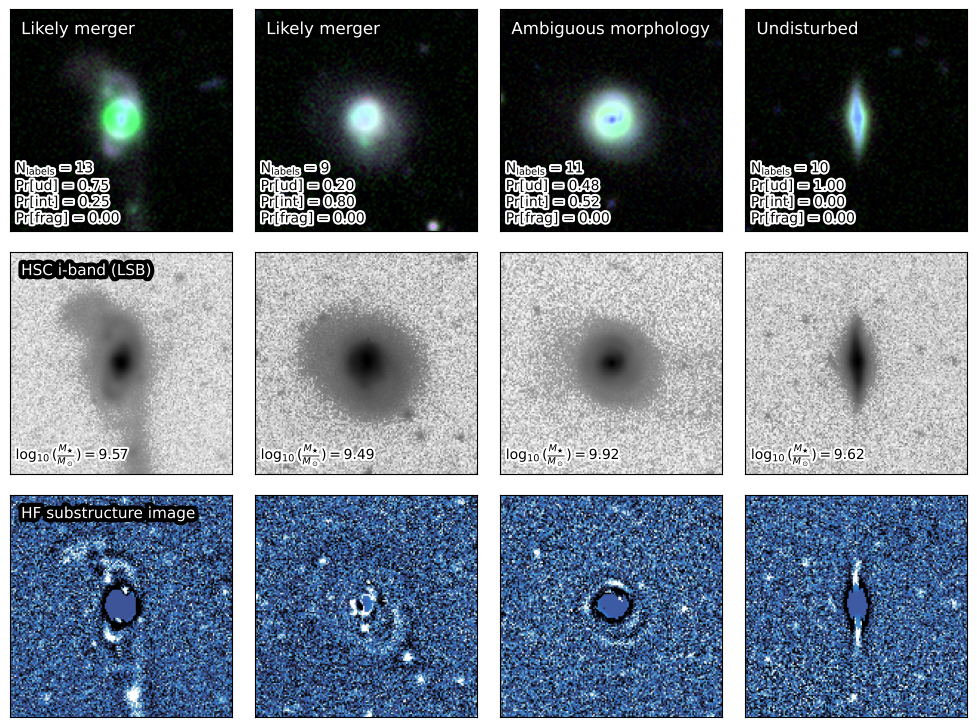

In [399]:
import cmasher
cmap = cmasher.arctic

# Get visualization parameters from config
from ekfplot import colors as ec, colorlists

viz_config = figures_config['visualization']
fig_config = figures_config['figure_output']

n_galaxies = len(all_selected)
n_viz_types = 3

# Figure dimensions - TRANSPOSED: rows are viz types, columns are galaxies
fig_width = fig_config['figsize']['width'] / 3. * n_galaxies
fig_height = fig_config['figsize']['height_per_galaxy'] * n_viz_types

print(f"🎨 Creating {n_viz_types}×{n_galaxies} visualization grid (rows=viz types, cols=galaxies)")

# Create figure with TRANSPOSED dimensions
fig, axarr = plt.subplots(n_viz_types, n_galaxies, figsize=(fig_width, fig_height))

# Handle case where we only have one visualization type (axarr would be 1D)
if n_viz_types == 1:
    axarr = axarr.reshape(1, -1)
# Handle case where we only have one galaxy (axarr would be 1D)
if n_galaxies == 1:
    axarr = axarr.reshape(-1, 1)

for col_idx, gix in enumerate(all_selected):
    # Row 0: r-N708-i RGB image
    bbmb = bbmb_d[gix]
    current_img = load_image_by_name(img_names[gix], data_path)
    if bbmb is None:
        # Fallback: use i-band grayscale
        
        if EKFPLOT_AVAILABLE:            
            ek.imshow(
                current_img[1],
                origin='lower',
                cmap='Greys',
                q=0.01,
                ax=axarr[0, col_idx]
            )
        else:
            axarr[0, col_idx].imshow(
                current_img[1],
                origin='lower',
                cmap='Greys',
                norm=colors.AsinhNorm()
            )
    else:
        rgb = make_lupton_rgb(
            bbmb.image['r'], 
            bbmb.image['N708'], 
            bbmb.image['i'], 
            Q=viz_config['lupton']['Q'], 
            stretch=viz_config['lupton']['stretch']
        )
        if EKFPLOT_AVAILABLE:
            ek.imshow(rgb, ax=axarr[0, col_idx])
        else:
            axarr[0, col_idx].imshow(rgb)
            axarr[0, col_idx].set_aspect('equal')
    
    # Row 1: HSC i-band (LSB with SymLog normalization)
    axarr[1, col_idx].imshow(
        current_img[1],
        origin='lower',
        cmap=viz_config['lsb']['colormap'],
        norm=colors.SymLogNorm(linthresh=viz_config['lsb']['linthresh'])
    )
    
    # Row 2: Starlet HF
    ek.imshow(
        current_img[2],
        ax=axarr[2, col_idx],
        cmap=cmap,
        qlow=0.05,
        qhigh=0.99,
    )

    # Add probability labels to first row (RGB images)
    label_config = viz_config['labels']
    label_text = rf'''N$_{{{{\rm labels}}}}$ = {n_labels_iter[gix]}
Pr[ud] = {prob_labels_iter[gix, 1]:.2f}
Pr[int] = {prob_labels_iter[gix, 3] + prob_labels_iter[gix, 2]:.2f}
Pr[frag] = {prob_labels_iter[gix, 4]:.2f}'''
    
    if EKFPLOT_AVAILABLE:
        ek.text(
            0.025,
            0.025,
            label_text,
            ax=axarr[0, col_idx],
            fontsize=label_config['fontsize'],
            bordercolor=label_config['bordercolor'],
            color=label_config['textcolor'],
            borderwidth=label_config['borderwidth']
        )
    else:
        axarr[0, col_idx].text(
            0.025, 0.025, label_text,
            transform=axarr[0, col_idx].transAxes,
            fontsize=label_config['fontsize'],
            color=label_config['textcolor'],
            verticalalignment='bottom',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
        )

    # Add stellar mass to second row (i-band images)
    with open(f"{main_config['data']['input_path']}/{img_names[gix]}/{img_names[gix]}_i_results.pkl", 'rb') as f:
        x = pickle.load(f)
        logmstar = x['logmass_adjusted']

    mass_text = rf'''$\log_{{{{10}}}}(\frac{{{{M_{{{{\bigstar}}}}}}}}{{{{M_\odot}}}})={logmstar:.2f}$'''
    ek.text(
        0.025,
        0.025,
        mass_text,
        ax=axarr[1, col_idx],
        fontsize=label_config['fontsize'],
        bordercolor=label_config['bordercolor'],
        color=label_config['textcolor'],
        borderwidth=label_config['borderwidth']
    )


# Add column headers (galaxy labels) to top row
row_labels = viz_config['row_labels']
if MASS_REGIME == 'highmass':
    label_order = ['merger', 'merger', 'ambiguous', 'undisturbed']
else:
    label_order = ['merger','ambiguous','undisturbed','fragmented']
    
for col_idx, label_key in enumerate(label_order[:n_galaxies]):
    if label_key in row_labels:
        ek.text(
            0.05, 
            0.95, 
            row_labels[label_key], 
            ax=axarr[0, col_idx], 
            fontsize=label_config['fontsize_title'], 
            bordercolor='k', 
            color='w', 
            borderwidth=6
        )


# Add row labels (visualization types) to first column
headers = viz_config['headers']
if headers['col1']:
    ek.text(
        0.05, 0.95, 
        headers['col1'], 
        ax=axarr[1, 0], 
        fontsize=label_config['fontsize_header'], 
        bordercolor='k', 
        color='w', 
        borderwidth=6
    )


if headers['col2']:
    ek.text(
        0.05, 0.95, 
        headers['col2'], 
        ax=axarr[2, 0], 
        fontsize=label_config['fontsize_header'], 
        bordercolor='k', 
        color='w', 
        borderwidth=6
    )


# Remove ticks from all axes
for ax in axarr.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust spacing
plt.tight_layout()
plt.subplots_adjust(wspace=fig_config['wspace'], hspace=fig_config['hspace'])

plt.tight_layout ()

print("✅ Figure generated successfully!")

## Save Figure

In [400]:
# Save figure
output_dir = Path('./punchline_figures/')
output_dir.mkdir(parents=True, exist_ok=True)
                 
filename = fig_config['filename_pattern'].format(mode=MASS_REGIME)
output_path = output_dir / filename

fig.savefig(output_path, dpi=fig_config['dpi'], bbox_inches='tight')
print(f"✅ Figure saved to: {output_path}")

✅ Figure saved to: punchline_figures/galaxy_examples_highmass.pdf
